# Polarization calibration using VELA taken by ASKAP & Parkes
getting phase, delay solutions for polarization calibration with vela data.
working directory: /fred/oz002/users/hcho
1. run ./craft/python/do_polcal.sh to make non-polarization calibrated vela data in .npy format
2. run ./FRB181112/do_all.sh to make psrchive file

In [1]:
import psrchive
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.optimize import bisect

In [2]:
def get_stokes(arch):
    # arch : psrchive format
    nsubint = arch.get_nsubint() # only gets nsubint = 1 for now.
    nchan = arch.get_nchan()
    nbin = arch.get_nbin()
    arch.remove_baseline()
    data = arch.get_data()
    if arch.get_state() == 'Stokes':
        print('Stokes Parameters: I Q U V')
        I,Q,U,V = data[0,:,:,:]
    elif arch.get_state() == 'Coherence':
        print('Coherence Matrix: XX YY XY.real XY.imag')
        XX,YY,XYreal,XYimag = data[0,:,:,:]
        I = XX + YY
        Q = XX - YY
        U = 2 * XYreal
        V = 2 * XYimag
    else:
        print("WHAT IS THIS STATE?")
    return I,Q,U,V
def average(d,avlen1,avlen2,norm1=True,norm2=True):
    avnum1 = int(np.shape(d)[0]/avlen1)
    avnum2 = int(np.shape(d)[1]/avlen2)
    av_out = np.zeros((avnum1,avnum2))

    for i in range(avnum1):
        for j in range(avnum2):
            av_out[i,j] = np.mean(d[i*avlen1:(i+1)*avlen1,j*avlen2:(j+1)*avlen2])
    
    if norm2:
        for j in range(avnum2):
            if np.var(av_out[:,j]) != 0:
                av_out[:,j] = (av_out[:,j]-np.mean(av_out[:,j]))/np.var(av_out[:,j])
            else:
                print('!c')
                av_askap[:,j] = np.nan
    if norm1:
        for i in range(avnum1):
            mean = np.mean(av_out[i,:])
            var = np.var(av_out[i,:])
            av_out[i,:] = (av_out[i,:]-mean)/var
            
            
    return av_out
def plot(_d, _f0=None, _bw=336, _freqs=None, _outfile=None, _passed_ax=None, _bool_pts=0, _label=None):
    plt.rcParams.update({'font.size': 18})
    if _passed_ax:
        ax = _passed_ax
    else:
        print('ax not passed')
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1,1,1)
        fig.subplots_adjust(left=0.2, bottom=0.1)
    if _freqs is None:
        fmin = _f0-float(_bw-1)/2
        fmax = _f0+float(_bw-1)/2
        freqs = np.linspace(fmax,fmin,len(_d))
    else:
        freqs = _freqs
    if _bool_pts:
        mks = '2'
        if _bool_pts >2:
            mks = str(_bool_pts)
        ax.plot(freqs, _d,'.',ms=mks,label=_label)
    else:
        ax.plot(freqs, _d,label=_label)
    ax.set_xlabel('freqency (MHz)')
    ax.set_ylabel('intensity (arb. units)')

    if not _passed_ax:
        print('showing figure')
        plt.show()
    else:
        return ax
def tscrunch(stokes, start=0, end=-1, avlen=None):
    outd = np.mean(stokes[:,start:end],axis=1)
    #print(np.shape(outd))
    if avlen is not None:
        outd = outd[:int(float(len(outd))/avlen)*avlen]
        outd = np.mean(outd.reshape(-1,avlen),axis=1)
    return outd
def faraday_angle(freq_mhz, RM=30,offset=0):
    #RM = 30
    lamb = 3e8/(freq_mhz*1e6)
    return RM*np.power(lamb,2)+offset
def QoverI(pa,amp):
    return amp*np.cos(2*pa)
def UoverI(pa,amp):
    return amp*np.sin(2*pa)

## Read in ASKAP VELA archive data

In [3]:
prereset = False
if prereset:
    fn = './vela/vela_nopolcal_prereset.DS'
else:
    fn = './vela/vela_nopolcal.DS'
#fn = './vela/vela_polcal_test191220.DS'
arch = psrchive.Archive_load(fn)
I,Q,U,V=get_stokes(arch)

Stokes Parameters: I Q U V


## Plot stokes parameters as functions of (nu,t)

In [4]:
np.shape(I)

(18144, 1024)

Text(0.5,0,'Pulse phase')

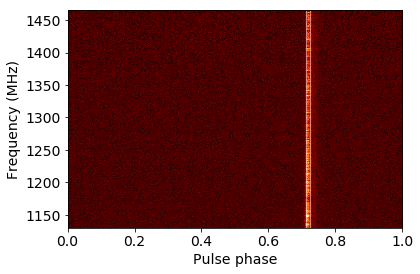

In [5]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
if prereset:
    start=493
    end=497
else:
    start = 729#733
    end = 740 #737
nbin = arch.get_nbin()
freqs = np.linspace(1465.,1130.,336)
plt.imshow(average(I,54,1,False,False),aspect='auto',extent=[0, 1,freqs[-1],freqs[0]],cmap=plt.get_cmap('gist_heat'))
if 1:
    plt.axvline(float(start)/nbin,color='w',linewidth='0.5')
    plt.axvline(float(end)/nbin,color='w',linewidth='0.5')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Pulse phase')
#plt.xlim([0.4,0.6])

## Time scrunch
time scrunch, and frequency average(optional)

In [6]:
avlen=54*2
test_Qsign= False #True
if test_Qsign:
    qfactor = -1 # change sign of Q
else:
    qfactor = 1
I_f = tscrunch(I,start,end,avlen)/1e6
Q_f = tscrunch(qfactor*Q,start,end,avlen)/1e6 # HC TEST for test -Q
U_f = tscrunch(U,start,end,avlen)/1e6
V_f = tscrunch(V,start,end,avlen)/1e6

noise_window = 60
pad=15
noise_start1 = start-13-noise_window #720-noise_window
noise_stop1 = start-13 #720 #start-pad
noise_start2 = end+13 #750
noise_stop2 = end+13+noise_window #750+noise_window
I_noise = (tscrunch(I,start=noise_start1,end=noise_stop1,avlen=avlen)/1e6+tscrunch(I,start=noise_start2,end=noise_stop2,avlen=avlen)/1e6)/2 
#start=start-30,
Q_noise = (tscrunch(Q,start=noise_start1,end=noise_stop1,avlen=avlen)/1e6+tscrunch(Q,start=noise_start2,end=noise_stop2,avlen=avlen)/1e6)/2
U_noise = (tscrunch(U,start=noise_start1,end=noise_stop1,avlen=avlen)/1e6+tscrunch(U,start=noise_start2,end=noise_stop2,avlen=avlen)/1e6)/2
V_noise = (tscrunch(V,start=noise_start1,end=noise_stop1,avlen=avlen)/1e6+tscrunch(V,start=noise_start2,end=noise_stop2,avlen=avlen)/1e6)/2

In [7]:
np.shape(I_f)

(168,)

## Plot each of the 4 stokes parameters

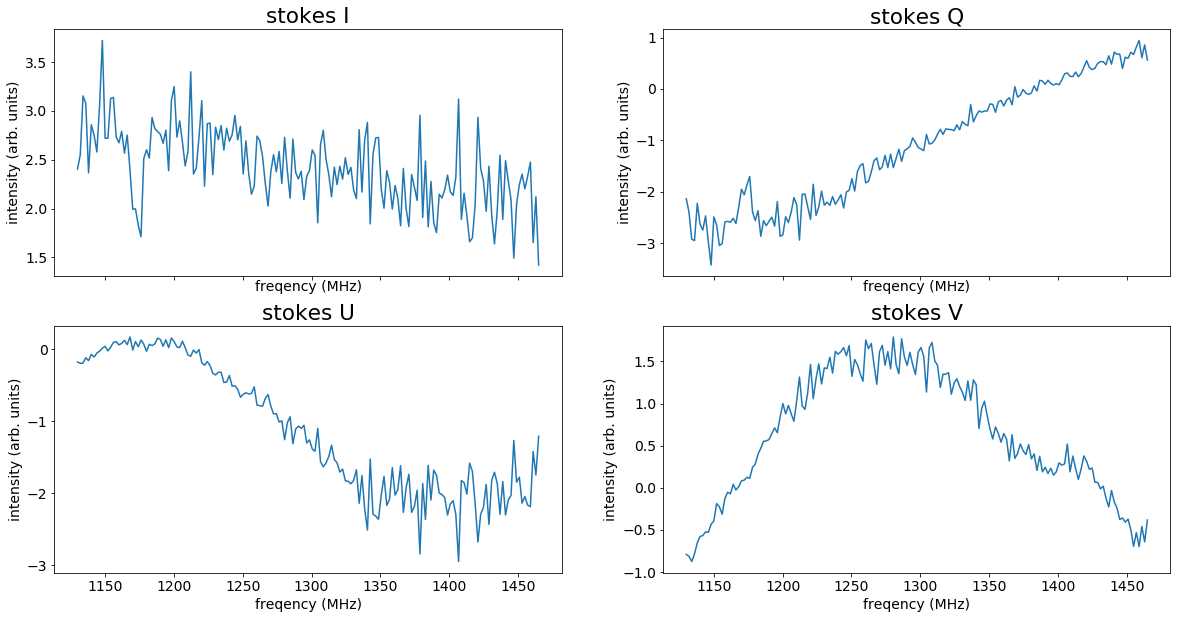

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey=False, figsize=(20, 10))
f0=1297.5
stokes = [I_f,Q_f,U_f,V_f]
stokes_noise = [I_noise,Q_noise,U_noise,V_noise]
stokes_name = ['stokes I','stokes Q','stokes U','stokes V']
for i in range(2):
    for j in range(2):
        ax[i,j] = plot(stokes[i*2+j]-stokes_noise[i*2+j],f0,_passed_ax=ax[i,j])
        ax[i,j].set_title(stokes_name[i*2+j])

## Plot stokes ratio (Q/I, U/I, V/I)

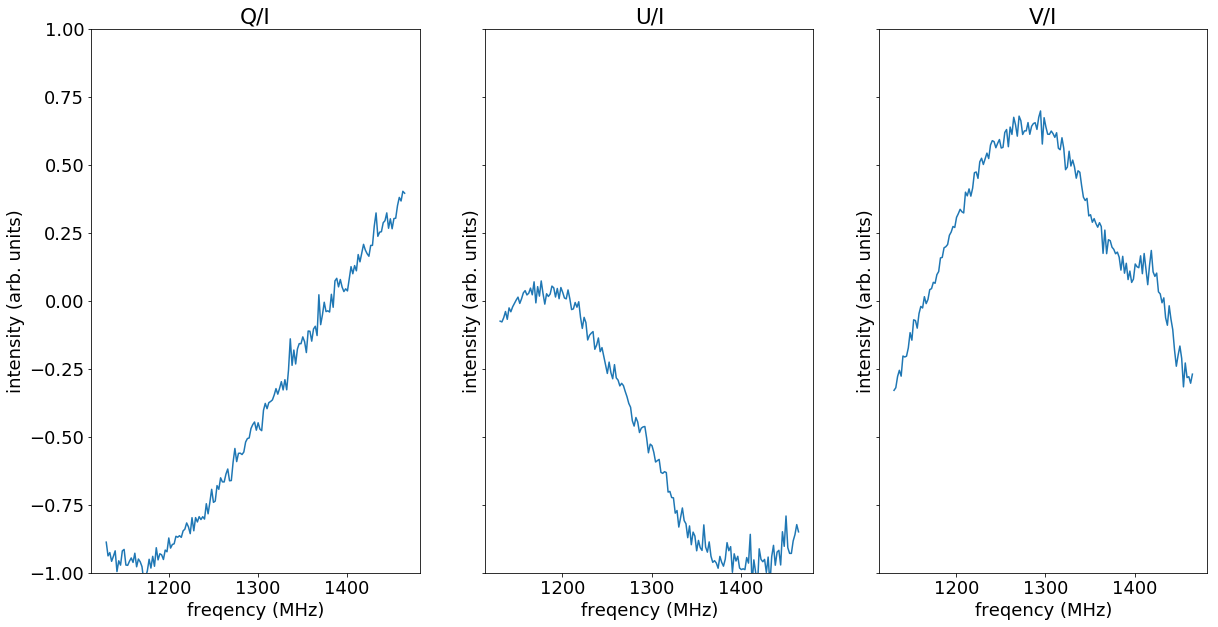

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey=True, figsize=(20, 10))
f0=1297.5
stokes_ratio = [Q_f/I_f,U_f/I_f,V_f/I_f]
stokes_noisefree = []
stokes_ratio_name = ['Q/I','U/I','V/I']
for i in range(3):
    stokes_noisefree+=[(stokes[i+1]-stokes_noise[i+1])/(stokes[0]-stokes_noise[0])]
    ax[i] = plot(stokes_noisefree[i],_f0=f0,_passed_ax=ax[i]) #stokes_ratio[i]
    ax[i].set_title(stokes_ratio_name[i])
    ax[i].set_ylim([-1,1])

#### Get p for ASKAP

(array([0.93354043]), 0.93354046)


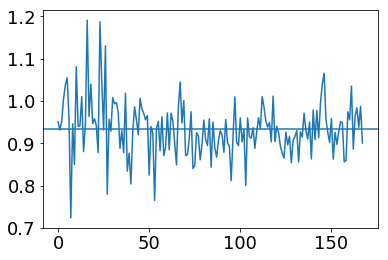

In [10]:
p_f = np.power(stokes_noisefree[0],2)+np.power(stokes_noisefree[1],2)+np.power(stokes_noisefree[2],2)
plt.plot(p_f)
z = np.polyfit(np.arange(len(p_f)),p_f,0)
mean = np.mean(p_f)
plt.axhline(mean)
print(z,mean)
#plt.ylim([0,1])

## VELA spectrum from Parkes

In [11]:
vela_pks = np.loadtxt("./vela/vela_spec_pks_20180920.dat", dtype={'names': ('freq_ghz', 'I', 'Q', 'U', 'V', 'PA'),\
                                                      'formats': ('f4', 'f4', 'f4', 'f4', 'f4', 'f4')})

In [12]:
def sin_func(pa,a,off):
    # pa should be in radians
    return a*np.sin(2*pa)+off #b*np.cos(2*pa)+

('frequency range: ', 1497.0, 1241.25)
-0.055098753


/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-2.7.14/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


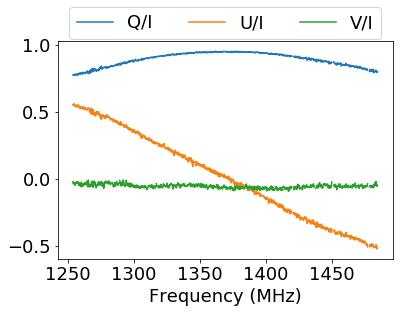

In [13]:
freq_mhz= vela_pks['freq_ghz']*1e3
print('frequency range: ',freq_mhz[0],freq_mhz[-1])
stokes_ratio_pks = [np.copy(vela_pks['Q'])/vela_pks['I'],np.copy(vela_pks['U'])/vela_pks['I'],np.copy(vela_pks['V'])/vela_pks['I']]
pa = np.copy(vela_pks['PA']) #
for i in range(3):
    plt.plot(freq_mhz, stokes_ratio_pks[i],label=stokes_ratio_name[i])
print(np.mean(stokes_ratio_pks[2][~np.isnan(stokes_ratio_pks[2])]))

plt.xlabel('Frequency (MHz)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)

# check PA by calculating myself from U,Q
if 0:
    plt.figure()
    plt.plot(freq_mhz,pa)
    plt.plot(freq_mhz,np.arctan2(np.copy(vela_pks['U']),np.copy(vela_pks['Q']))/2*180/np.pi,alpha=0.5)
    #plt.plot(freq_mhz,np.arctan2(np.copy(vela_pks['U']),-np.copy(vela_pks['Q']))/2*180/np.pi-180,alpha=0.5)
    #plt.plot(freq_mhz,np.arctan2(np.copy(-vela_pks['U']),np.copy(vela_pks['Q']))/2*180/np.pi,alpha=0.5)

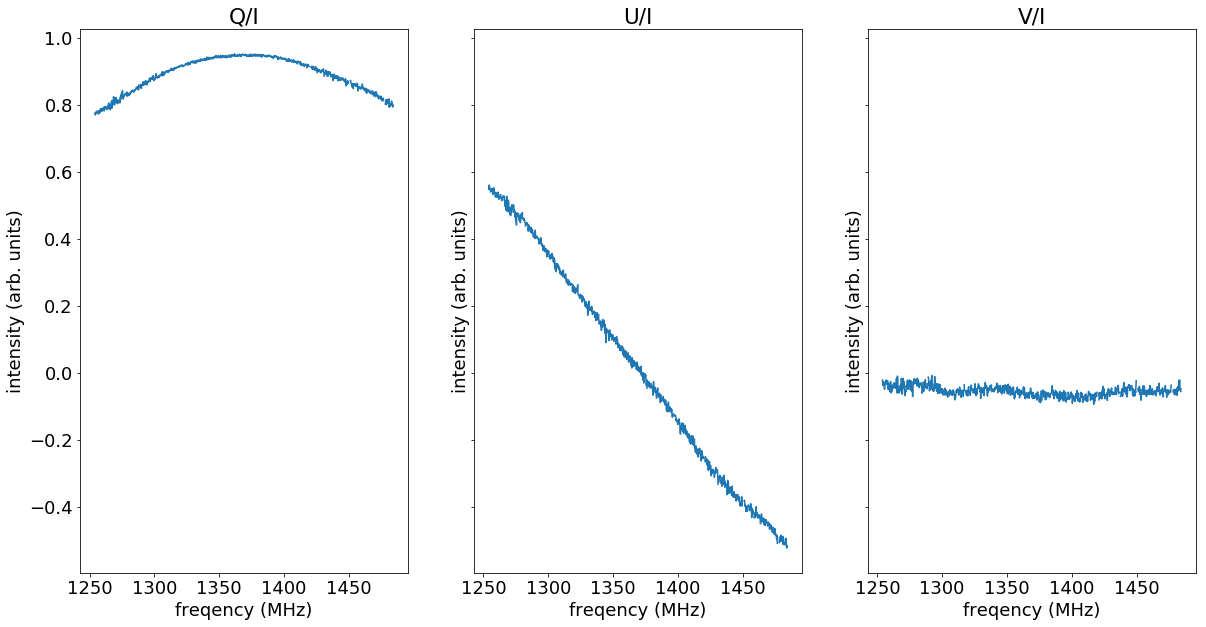

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey=True, figsize=(20, 10))
f0=1297.5
#coeff = np.full((3,3))
for i in range(3):
    ax[i] = plot(stokes_ratio_pks[i],_freqs=freq_mhz,_passed_ax=ax[i]) #stokes_ratio[i]
    ax[i].set_title(stokes_ratio_name[i])

#### Measure p for Parkes

0.9027267

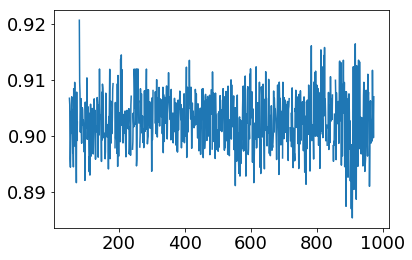

In [15]:
linearIntensity = np.power(stokes_ratio_pks[0],2)+np.power(stokes_ratio_pks[1],2)+np.power(stokes_ratio_pks[2],2)
nan = np.isnan(linearIntensity)
plt.plot(np.power(stokes_ratio_pks[0],2)+np.power(stokes_ratio_pks[1],2)+np.power(stokes_ratio_pks[2],2))
np.mean(linearIntensity[~nan])

In [16]:
np.mean(stokes_ratio_pks[2][~nan])

-0.055098753

#### Parkes Position angle fit ($\psi(\nu)$) : Get $RM$ and $offset$

In [17]:
def faraday_angle(freq_mhz, RM=30,offset=0):
    #RM = 30
    lamb = 3e8/(freq_mhz*1e6)
    return RM*np.power(lamb,2)+offset

('RM', 37.43534317649634, 'offset', -1.80339213320941)
[[ 5.82883456e-03 -2.82206848e-04]
 [-2.82206848e-04  1.37923144e-05]]


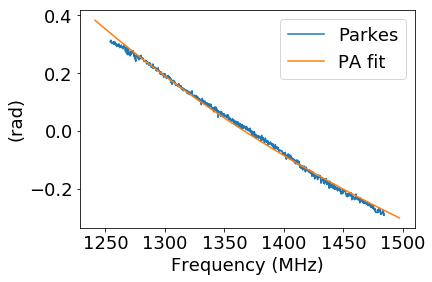

In [18]:
nonzero = np.where(pa!=0)
pa_tofit = np.copy(pa)
plt.plot(freq_mhz[nonzero],pa_tofit[nonzero]/180.*np.pi,label='Parkes')
popt, pcov = curve_fit(faraday_angle, freq_mhz[nonzero], pa_tofit[nonzero]/180.*np.pi,p0=(-30,-.2))
plt.plot(freq_mhz,faraday_angle(freq_mhz,popt[0],popt[1]),label='PA fit')
rm = popt[0]
offset = popt[1]
print('RM',rm,'offset',offset)
print(pcov)
plt.ylabel('(rad)')
plt.xlabel('Frequency (MHz)')
plt.legend()

#### Determine Parkes L/I ($L_{amp}$) via fitting for Q/I using $\psi(\nu)$ from above

('$L_{amp}$', 0.9478899469229247)
('$L_{amp}$', 0.9504402528893675)
('mean $L_{amp}$', 0.9491650999061461)


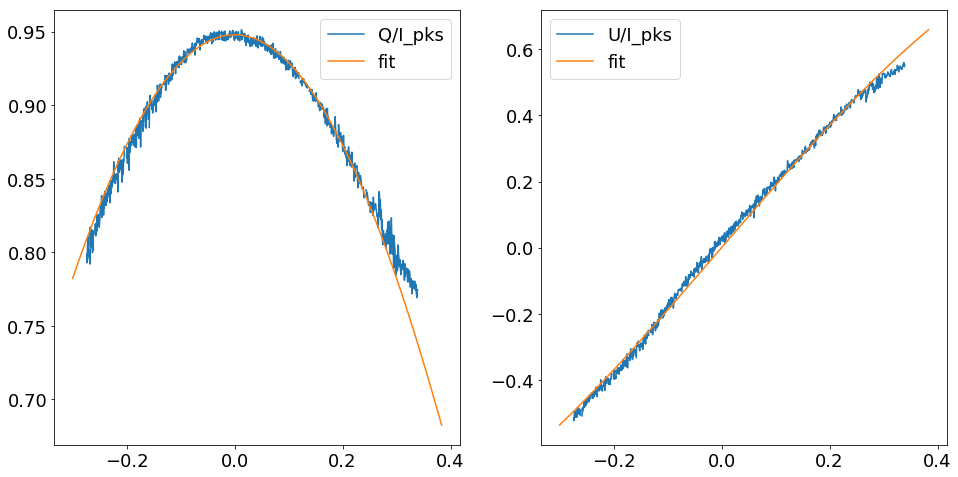

In [19]:
pa = faraday_angle(freq_mhz,rm,offset)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
nan = (np.isnan(stokes_ratio_pks[0]))
popt, pcov = curve_fit(QoverI, pa[~nan], stokes_ratio_pks[0][~nan])
ax[0].plot(pa,stokes_ratio_pks[0],label='Q/I_pks')
ax[0].plot(pa,QoverI(pa,popt[0]),label='fit')
ax[0].legend()
L_amp1 = popt[0]
print(r'$L_{amp}$',L_amp1)
nan = (np.isnan(stokes_ratio_pks[1]))
popt, pcov = curve_fit(UoverI, pa[~nan], stokes_ratio_pks[1][~nan])
ax[1].plot(pa,stokes_ratio_pks[1],label='U/I_pks')
ax[1].plot(pa,UoverI(pa,popt[0]),label='fit')
ax[1].legend()
L_amp2 = popt[0]
print(r'$L_{amp}$',L_amp2)
#plt.plot(0.95*np.cos(2*pa))
L_amp = (L_amp1+L_amp2)/2
print(r'mean $L_{amp}$', L_amp)

In [20]:
np.isnan(stokes_ratio_pks[0])

array([ True,  True,  True, ...,  True,  True,  True])

#### determine ASKAP $\psi_{sky}$

$\psi'(\nu) = \psi(\nu) + \psi_{sky}$

('$\\psi_{sky}$', 0.8344657652718706)


Text(0,0.5,'Q/I')

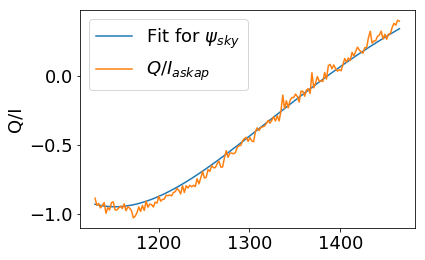

In [21]:
def QoverI_askap(Lamp):
    def QoverI_for_Lamp(pa,psi_sky):
        return Lamp*np.cos(2*(pa+psi_sky))
    return QoverI_for_Lamp
QoverI_askap_for_given_Lamp=QoverI_askap(L_amp) 
f0=1297.5
fmin = f0-335./2
fmax = f0+335./2
freqs_askap = np.linspace(fmax,fmin,len(stokes[0]))
pa_askap = faraday_angle(freqs_askap,rm,offset)
Q_askap=np.copy(stokes_noisefree[0]) # not now: (old) qfactor* JUST FOR TEST, change back sign for sky angle measurement
popt, pcov = curve_fit(QoverI_askap_for_given_Lamp, pa_askap, Q_askap)
plt.plot(freqs_askap,QoverI_askap_for_given_Lamp(pa_askap,*popt),label=r'Fit for $\psi_{sky}$')
plt.plot(freqs_askap,Q_askap,label=r'$Q/I_{askap}$') #pa_askap
plt.legend()
psi_sky = popt[0]
print(r'$\psi_{sky}$',psi_sky)
plt.ylabel('Q/I')

Same as above, but fit for L_amp as well

[-0.74153414 -0.98657945]
('$\\psi_{sky}$', -0.7415341388278138)
('$\\psi_{sky}$', -0.7415341388278138)


Text(0,0.5,'Q/I')

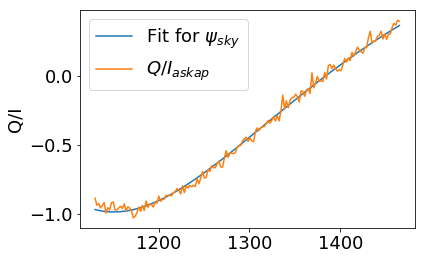

In [22]:
def QoverI_askap_fit_Lamp(pa,psi_sky,Lamp):
    return Lamp*np.cos(2*(pa+psi_sky))
f0=1297.5
fmin = f0-335./2
fmax = f0+335./2
freqs_askap = np.linspace(fmax,fmin,len(stokes[0]))
pa_askap = faraday_angle(freqs_askap,rm,offset)
Q_askap= np.copy(stokes_noisefree[0]) # qfactor*
popt, pcov = curve_fit(QoverI_askap_fit_Lamp, pa_askap, Q_askap,p0=[-0.8,0.95])
plt.plot(freqs_askap,QoverI_askap_fit_Lamp(pa_askap,*popt),label=r'Fit for $\psi_{sky}$')
plt.plot(freqs_askap,Q_askap,label=r'$Q/I_{askap}$') #pa_askap
plt.legend()
psi_sky = popt[0]
L_amp = popt[1]
print(popt)
print(r'$\psi_{sky}$',psi_sky)
print(r'$\psi_{sky}$',psi_sky)
plt.ylabel('Q/I')

In [23]:
Q_askap= stokes_ratio[0]
Q_pks = stokes_ratio_pks[0]
U_askap = stokes_ratio[1]
U_pks = stokes_ratio_pks[1]

## Solving using matrices

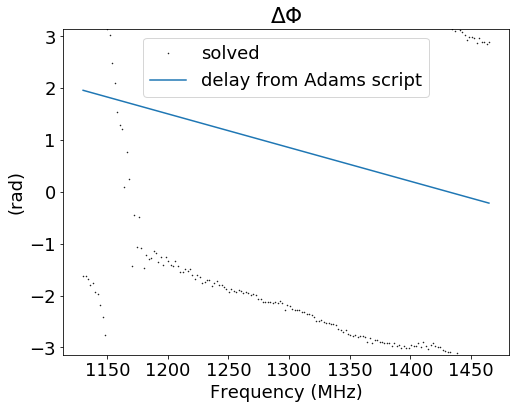

In [24]:
plt.figure(figsize=(8, 6))
tan_phi = np.full((len(stokes_noisefree[1]),2),np.nan)
for nu in range(len(stokes_noisefree[1])):
    u_prime = np.copy(stokes_noisefree[1][nu])
    v_prime = np.copy(stokes_noisefree[2][nu]) #-1*qfactor*
    pa_prime = psi_sky + faraday_angle(freqs_askap[nu],rm,offset)
    u = L_amp * np.sin(2*pa_prime)
    v = 0.05
    A = np.array([[u+v, v-u],[u-v, u+v]]) #np.array([[u+v, u-v],[-u+v, u+v]])/(4*u*v)
    x = np.array([[u_prime+v_prime],[u_prime-v_prime]])
    y = np.matmul(np.linalg.inv(A),x)
    #plt.plot(nu,np.linalg.norm(y),'.')
    tan_phi[nu,0] = y[0]
    tan_phi[nu,1] = y[1]
    #plt.plot(freqs_askap[nu],np.arctan2(y[1],y[0]),'.',color='k',ms='1')
    
    #if abs(np.linalg.norm(y) -1)>1:
     #   print(np.linalg.norm(y))
plt.plot(freqs_askap,np.arctan2(tan_phi[:,1],tan_phi[:,0]),'.',color='k',ms='1',label='solved')
deltat=-1.03234e-3 # us
plt.plot(freqs_askap,np.angle(np.exp(2j*np.pi*freqs_askap*deltat+3j)),label='delay from Adams script')
plt.ylim([-1*np.pi,np.pi])
plt.title(r'$\Delta\Phi$')
plt.xlabel('Frequency (MHz)')
plt.ylabel('(rad)')
plt.legend()

/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-2.7.14/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.
/apps/skylake/software/compiler/gcc/6.4.0/ipython/5.5.0-python-2.7.14/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


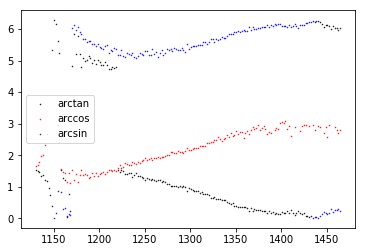

In [25]:
%matplotlib inline
plt.plot(freqs_askap,np.mod(np.arctan(np.copy(tan_phi[:,1])/np.copy(tan_phi[:,0])),2*np.pi),'.',color='k',ms='1',label='arctan')
#plt.plot(freqs_askap,np.arctan2(np.copy(tan_phi[:,1]),np.copy(tan_phi[:,0])),'.',color='k',ms='1',label='arctan')
plt.plot(freqs_askap,np.mod(np.arccos(np.copy(tan_phi[:,0])),2*np.pi),'.',color='r',ms='1',label='arccos') # arccos
plt.plot(freqs_askap,np.mod(np.arcsin(np.copy(tan_phi[:,1])),2*np.pi),'.',color='b',ms='1',label='arcsin') # arcsin
#plt.plot(freqs_askap,np.power(tan_phi[:,1],2)+np.power(tan_phi[:,0],2),'.',color='k',ms='1',label='norm')
plt.legend()

[-7.14013933e-03  1.33126962e+01]


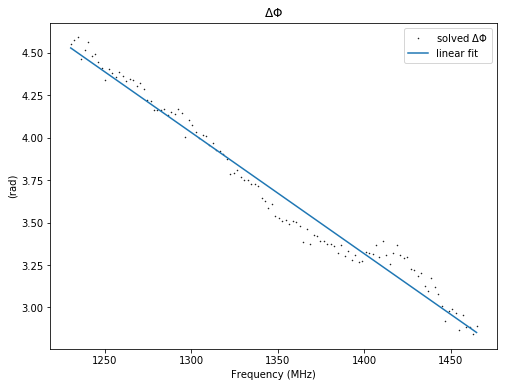

In [26]:
plt.figure(figsize=(8, 6))
stop=-50
phi_tofit = np.arctan2(np.copy(tan_phi[:stop,1]),np.copy(tan_phi[:stop,0]))#+np.pi/2
if 1:
    phi_tofit = np.mod(phi_tofit, 2*np.pi)
    #phi_tofit = np.array([p if p<0 else p-2*np.pi for p in phi_tofit])
plt.plot(freqs_askap[:stop],phi_tofit,'.',color='k',ms='1',label=r'solved $\Delta\Phi$')
z,pcov = np.polyfit(freqs_askap[:stop],phi_tofit,1,cov=True)
perr = np.sqrt(np.diag(pcov))
print(z)
p = np.poly1d(z)
plt.plot(freqs_askap[:stop],p(freqs_askap[:stop]),label='linear fit')
#plt.ylim([-1*np.pi,np.pi])
plt.title(r'$\Delta\Phi$')
plt.xlabel('Frequency (MHz)')
plt.ylabel('(rad)') 
plt.legend()

In [27]:
delay = np.array([z[0],perr[0]])/2/np.pi/1e6*1e9 # ns
print("polarization delay {}+-{} ns".format(delay[0],delay[1]))
offset = np.array([z[1],perr[1]])
print("polarization phase offset {}+-{}".format(offset[0],offset[1]))

polarization delay -1.13638846943+-0.0170800074398 ns
polarization phase offset 13.3126961548+-0.144811299489


In [67]:
print(delay[0]-delay[1])
print(offset[0]+offset[1])

-1.1568853748356676
10.347862410779019


## Checking $\Delta\Phi$ solutions

In [128]:
uv_prime = np.full((len(stokes_noisefree[1]),2),np.nan)

for nu in range(len(stokes_noisefree[1])):
    pa_prime = psi_sky + faraday_angle(freqs_askap[nu],rm,offset)
    u = L_amp * np.sin(2*pa_prime)
    v = -0.05
    #cos = tan_phi[nu,0]
    #sin = tan_phi[nu,1]
    phi = p(freqs_askap[nu]) # np.arctan2(tan_phi[nu,1],tan_phi[nu,0])#
    cos = np.cos(phi)
    sin = np.sin(phi)
    phi_mat = np.array([[cos, sin],[-1*sin, cos]])
    uv_arr = np.array([[u],[v]])
    temp = np.matmul(phi_mat,uv_arr)
    uv_prime[nu,0] = temp[0]
    uv_prime[nu,1] = temp[1]
    


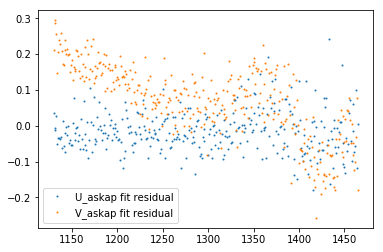

In [129]:
plt.plot(freqs_askap,uv_prime[:,0]-stokes_noisefree[1],'.',ms='2',label='U_askap fit residual')
plt.plot(freqs_askap,uv_prime[:,1]-stokes_noisefree[2],'.',ms='2',label='V_askap fit residual')
#plt.plot(freqs_askap,,'.',ms='2', label='V_askap')
plt.legend()

In [90]:
p = np.sqrt(0.9116806) #0.827) #0.73494136)
pcos = 0.95#0.98191421 #0.90751072 #0.89772418
VoverI = np.sqrt(np.power(p,2)-np.power(pcos,2))
print(p,pcos)
print(VoverI)

(0.9548196688380481, 0.95)
0.09581544760632277


In [45]:
p = np.sqrt(0.9027267)
VoverI = np.sqrt(np.power(p,2)-np.power(0.9491632746315193,2))
print(VoverI)

0.04261194774674303


## Pol Calibrated VELA Pulsar test

In [34]:
arch = psrchive.Archive_load('./vela/vela_polcal_fromfit.DS')
stokes_vela_after=get_stokes(arch)

Stokes Parameters: I Q U V


In [35]:
np.shape(stokes_vela_after)

(4, 18144, 1024)

Text(0.5,0,'Pulse phase')

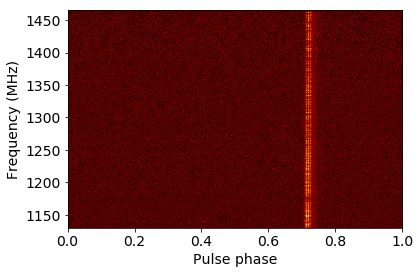

In [36]:
plt.rcParams.update({'font.size': 14})
start=733#720 #733
end=737#750 # 736
nbin = arch.get_nbin()
freqs = np.linspace(1465.,1130.,336)
plt.imshow(average(stokes_vela_after[0],54,1,False,False),aspect='auto',extent=[0, 1,freqs[-1],freqs[0]],cmap=plt.get_cmap('gist_heat'))
if 1:
    plt.axvline(float(start)/nbin,color='k',linewidth='0.5')
    plt.axvline(float(end)/nbin,color='k',linewidth='0.5')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Pulse phase')

In [37]:
avlen=54*2
noise_window = 60
noise_start1 = 720-noise_window
noise_stop1 = 720
noise_start2 = 750
noise_stop2 = 750+noise_window
stokes_vela_after_f = np.full((np.shape(stokes_vela_after)[0],int(float(np.shape(stokes_vela_after)[1])/avlen)),np.nan)
stokes_noise_after_f = np.full((np.shape(stokes_vela_after)[0],int(float(np.shape(stokes_vela_after)[1])/avlen)),np.nan)
for i in range(np.shape(stokes_vela_after)[0]):
    stokes_vela_after_f[i] = tscrunch(stokes_vela_after[i],start,end,avlen)/1e6
    noise_before = tscrunch(stokes_vela_after[i],start=noise_start1,end=noise_stop1,avlen=avlen)/1e6
    noise_after = tscrunch(stokes_vela_after[i],start=noise_start2,end=noise_stop2,avlen=avlen)/1e6
    stokes_noise_after_f[i] = (noise_before+noise_after)/2


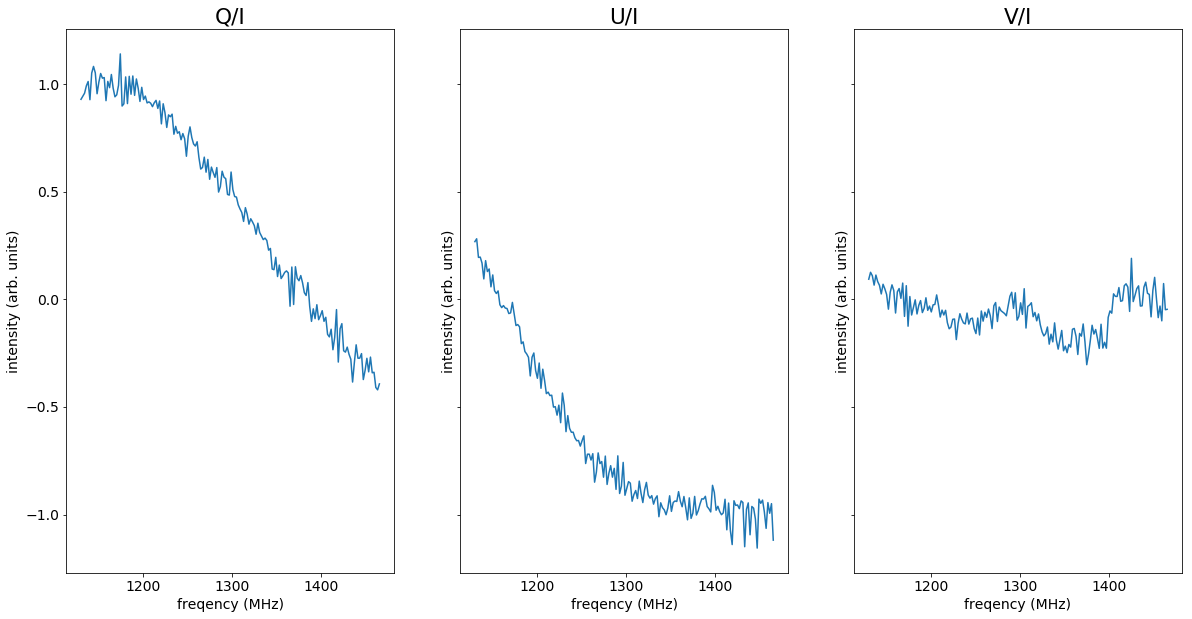

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey=True, figsize=(20, 10))
f0=1297.5
stokes_noisefree_after = []
for i in range(3):
    stokes_noisefree_after+=[(stokes_vela_after_f[i+1]-stokes_noise_after_f[i+1])/(stokes_vela_after_f[0]-stokes_noise_after_f[0])]
    #plt.plot(stokes_noisefree_after)
    ax[i] = plot(stokes_noisefree_after[i],_f0=f0,_passed_ax=ax[i]) #stokes_ratio[i]
    ax[i].set_title(stokes_ratio_name[i])

In [40]:
np.mean(stokes_noisefree_after[2])

-0.061918614724065915

#### Vela ASKAP data (after polcal) RM measure

('RM', 39.25128567386096, 'offset', -2.62714163009239)
[[ 0.04747308 -0.00258144]
 [-0.00258144  0.00014358]]


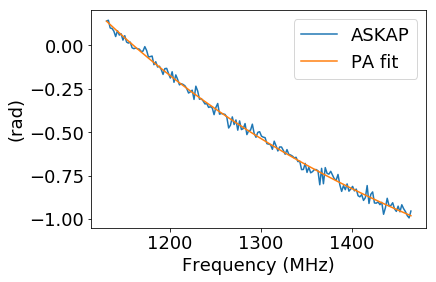

In [56]:
Q_temp = stokes_noisefree_after[0]
U_temp = stokes_noisefree_after[1]
pa_tofit = np.arctan2(np.copy(U_temp),np.copy(Q_temp))/2*180./np.pi
nonzero = np.where(pa_tofit!=0)
plt.plot(freqs_askap[nonzero],pa_tofit[nonzero]/180.*np.pi,label='ASKAP')
popt, pcov = curve_fit(faraday_angle, freqs_askap[nonzero], pa_tofit[nonzero]/180.*np.pi,p0=(30,2))
plt.plot(freqs_askap,faraday_angle(freqs_askap,popt[0],popt[1]),label='PA fit')
rm = popt[0]
offset = popt[1]
print('RM',rm,'offset',offset)
print(pcov)
plt.ylabel('(rad)')
plt.xlabel('Frequency (MHz)')
plt.legend()